# 3D analysis

This tutorial shows how to run a 3D map-based analysis (two spatial and one energy axis).

The example data is three observations of the Galactic center region with CTA.

## Imports and versions

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.extern.pathlib import Path
from gammapy.data import DataStore
from gammapy.irf import EnergyDispersion
from gammapy.maps import WcsGeom, MapAxis, Map
from gammapy.cube import MapMaker, PSFKernel, MapFit
from gammapy.cube.models import SkyModel
from gammapy.spectrum.models import PowerLaw
from gammapy.image.models import SkyGaussian

In [3]:
!gammapy info --no-envvar --no-dependencies --no-system


Gammapy package:

	path                   : /Users/deil/work/code/gammapy/gammapy 
	version                : 0.8.dev6384 
	githash                : 168842c7506cfbdc869a532beff3fa5eaf75ca52 



## Make maps

In [4]:
# Define which data to use
data_store = DataStore.from_dir(
    '$GAMMAPY_EXTRA/datasets/cta-1dc/index/gps/'
)
obs_ids = [110380, 111140, 111159]
# obs_ids = [110380]

In [5]:
# Define map geometry (spatial and energy binning)
axis = MapAxis.from_edges(
    np.logspace(-1., 1., 10), unit='TeV', name='energy'
)
geom = WcsGeom.create(
    skydir=(0, 0), binsz=0.02, width=(20, 15),
    coordsys='GAL', proj='CAR',
    axes=[axis],
)

In [6]:
%%time
maker = MapMaker(geom, 4. * u.deg)

for obs_id in obs_ids:
    print('processing:', obs_id)
    obs = data_store.obs(obs_id)
    maker.process_obs(obs)

# TODO: add this as a property `.results`? on the maker
maps = {
    'counts': maker.count_map,
    'background': maker.background_map,
    'exposure': maker.exposure_map,
}

processing: 110380
processing: 111140
processing: 111159
CPU times: user 27.1 s, sys: 3.06 s, total: 30.2 s
Wall time: 8.8 s


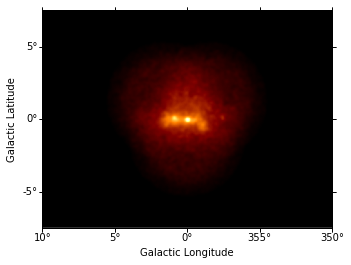

In [7]:
maps['counts'].sum_over_axes().smooth(radius=0.2*u.deg).plot();

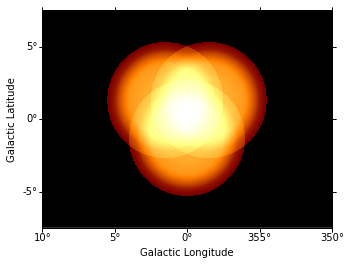

In [8]:
maps['background'].sum_over_axes().plot(stretch='sqrt');

## Compute PSF kernel

For the moment we rely on the ObservationList.make_mean_psf() method.

In [9]:
obs_list = data_store.obs_list(obs_ids)
src_pos = SkyCoord(0, 0, unit='deg', frame='galactic')

table_psf = obs_list.make_mean_psf(src_pos)
psf_kernel = PSFKernel.from_table_psf(
    table_psf,
    maker.exposure_map.geom,
    max_radius='1 deg',
)

## Compute energy dispersion

In [10]:
energy_axis = geom.get_axis_by_name('energy')
energy = energy_axis.edges * energy_axis.unit
edisp = obs_list.make_mean_edisp(position=src_pos, e_true=energy, e_reco=energy)

## Save maps

It's common to run the "precompute" step and the "likelihood fit" step separately,
because often the "precompute" of maps, PSF and EDISP is slow if you have a lot of data.

Here it woudn't really be necessary, because the precompute step (everything above this cell)
takes less than a minute.

But usually you would do it like this: write precomputed things to FITS files,
and then read them from your script that does the likelihood fitting without
having to run the precomputations again.

In [11]:
# Write
path = Path('analysis_3d')
path.mkdir(exist_ok=True)
maps['counts'].write(str(path / 'counts.fits'), overwrite=True)
maps['background'].write(str(path / 'background.fits'), overwrite=True)
maps['exposure'].write(str(path / 'exposure.fits'), overwrite=True)
psf_kernel.write(str(path / 'psf.fits'), overwrite=True)
edisp.write(str(path / 'edisp.fits'), overwrite=True)

In [12]:
# Read
maps = {
    'counts': Map.read(str(path / 'counts.fits')),
    'background': Map.read(str(path / 'background.fits')),
    'exposure': Map.read(str(path / 'exposure.fits')),
}
psf_kernel = PSFKernel.read(str(path / 'psf.fits'))
edisp = EnergyDispersion.read(str(path / 'edisp.fits'))

## Model fit

- TODO: Add diffuse emission model? (it's 800 MB, maybe prepare a cutout)
- TODO: make it faster (less than 1 minute)
- TODO: compare against true model known for DC1

In [13]:
spatial_model = SkyGaussian(
    lon_0='0 deg',
    lat_0='0 deg',
    sigma='0.1 deg',
)
spectral_model = PowerLaw(
    index=2.2,
    amplitude='3e-12 cm-2 s-1 TeV-1',
    reference='1 TeV',
)
model = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
)

In [14]:
# For now, users have to set initial step sizes
# to help MINUIT to converge
model.parameters.set_parameter_errors({
    'lon_0': '0.01 deg',
    'lat_0': '0.01 deg',
    'sigma': '0.1 deg',
    'index': 0.1,
    'amplitude': '1e-13 cm-2 s-1 TeV-1',
})

# model.parameters['lon_0'].frozen = True
# model.parameters['lat_0'].frozen = True
model.parameters['sigma'].frozen = True
model.parameters['sigma'].min = 0

In [15]:
%%time
fit = MapFit(
    model=model,
    counts=maps['counts'],
    exposure=maps['exposure'],
    background=maps['background'],
    psf=psf_kernel,
#     edisp=edisp,
)

fit.fit()

FCN = 791737.4766482912 
 TOTAL NCALL = 109 
 NCALLS = 109 
 
 
 EDM = 5.411610892977309e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,lon_0,-0.0489699,0.00603099,0,0,,,
2,lat_0,-0.0532021,0.00517017,0,0,,,
3,sigma,0.1,0.1,0,0,0.0,,FIXED
4,index,2.34823,0.0329683,0,0,,,
5,amplitude,4.8668e-12,2.03008e-13,0,0,,,
6,reference,1,0,0,0,0.0,,FIXED


CPU times: user 30min 30s, sys: 3min 35s, total: 34min 5s
Wall time: 8min 39s


In [16]:
print(model.parameters)

ParameterList
Parameter(name='lon_0', value=-0.04896994794396681, unit='deg', min=nan, max=nan, frozen=False)
Parameter(name='lat_0', value=-0.05320209350456812, unit='deg', min=nan, max=nan, frozen=False)
Parameter(name='sigma', value=0.1, unit='deg', min=0.0, max=nan, frozen=True)
Parameter(name='index', value=2.3612069061929533, unit='', min=nan, max=nan, frozen=False)
Parameter(name='amplitude', value=4.946727737339892e-12, unit='1 / (cm2 s TeV)', min=nan, max=nan, frozen=False)
Parameter(name='reference', value=1.0, unit='TeV', min=0.0, max=nan, frozen=True)

Covariance: 
[[ 3.63728796e-05  2.65410675e-07  0.00000000e+00 -7.94479589e-06
  -4.44382559e-18  0.00000000e+00]
 [ 2.65410675e-07  2.67307082e-05  0.00000000e+00 -1.36402754e-06
  -1.35747905e-17  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-7.94479589e-06 -1.36402754e-06  0.00000000e+00  1.08690745e-03
  -2.82192784e-15  0.00000000e+00]
 [-4.4438255

## Check model fit

- plot counts spectrum for some on region (e.g. the one used in 1D spec analysis, 0.2 deg)
- plot residual image for some energy band (e.g. the total one used here)

## Exercises

* Analyse the second source in the field of view: G0.9+0.1
* Run the model fit with energy dispersion (pass edisp to MapFit)